In [104]:
import pandas as pd
import numpy as np
import math
from scipy.stats import nbinom, gamma

import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [10, 10]

import seaborn as sns

import sys
sys.path.append("../measles_metapop/")
from gravity import *

In [126]:
# simulation parameters
num_patches=10
patch_pop=100000
initial_inf=1

# disease parameters
alpha=.90
beta = 10
recovery = 1 #recover after these number of timesteps?
#birth_rate .017 per year
birth = 100

# network model parameters
network_params = {
    "tau1":1,
    "tau2":1,
    "rho":1,
    "theta":.01/patch_pop
}

ITERS = 100

In [127]:
disease_matrix = np.zeros((num_patches,3))
disease_matrix[:,0]=patch_pop-initial_inf
#disease_matrix[:,1]=initial_inf

disease_matrix[:,0]=patch_pop
disease_matrix[5,0]=patch_pop-1
disease_matrix[5,1]=1

disease_matrix[:,0]=patch_pop
disease_matrix[9,0]=patch_pop-1
disease_matrix[9,1]=1

# sequence of state matrices
disease_matrix_ts = [disease_matrix]
delta_I_ts = [disease_matrix[:,1]]

# generate network
disease_network = random_network(n=num_patches,
                                 population=patch_pop,
                                mode="gaussian")


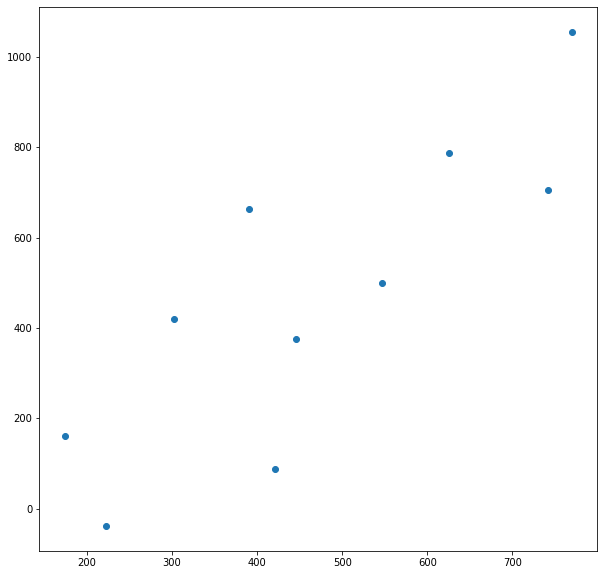

In [128]:
plt.scatter(data=disease_network,x='x',y='y')

In [129]:
for i in range(0,ITERS):
    last_matrix = disease_matrix_ts[-1]
    S_t, I_t, R_t = last_matrix[:,0], last_matrix[:,1], last_matrix[:,2]
    print("infection vector",I_t)
    #lambda_t = np.zeros(num_patches)
    delta_I_t = np.zeros(num_patches)
    
    grav_output = gravity(network=disease_network, 
                    infected=I_t, params=network_params)
    influx=grav_output["influx"]
    #print(influx)
    iota_t = np.array([gamma.rvs(scale=1,a=i) if i > 0 else 0 for i in influx])
    print(iota_t)
    
    for k in range(0,num_patches):
        if I_t[k] or iota_t[k] > 0: # new infections not getting introduced to other regions???
            lambda_t = (beta*S_t[k]*(I_t[k]+iota_t[k])**(alpha))/patch_pop
            #variance= lambda_t + (1/I_t[k])*(lambda_t**2)
            #p = lambda_t/variance
            n = I_t[k]+iota_t[k] # This allows the infection to spread to other regions. but is this actually correct?
            p = 1/(1+(lambda_t/n))
            
            try:
                delta_I_t[k] = min(S_t[k],nbinom.rvs(n,p))
            except ValueError:
                print("p",p,"n",n,"I_t[k]",I_t[k],variance)
        else:
            delta_I_t[k] = 0
            
    print("change in I",delta_I_t)
    if i >= recovery-1:
        delta_R_t = np.maximum(delta_I_ts[-(recovery)],0) # do recovery step
    else:
        delta_R_t=0
    delta_I_ts.append(delta_I_t)
    
    next_matrix = np.array([
        S_t-delta_I_t+birth,
        I_t+delta_I_t-delta_R_t,
        R_t+delta_R_t
    ]).T
    print(np.sum(next_matrix,axis=0))
    #print(np.sum(next_matrix,axis=1))
    disease_matrix_ts.append(next_matrix)

infection vector [0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
change in I [0. 0. 0. 0. 0. 4. 0. 0. 0. 6.]
[1.000989e+06 1.000000e+01 2.000000e+00]
infection vector [0. 0. 0. 0. 0. 4. 0. 0. 0. 6.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
change in I [ 0.  0.  0.  0.  0. 53.  0.  0.  0. 51.]
[1.001885e+06 1.040000e+02 1.200000e+01]
infection vector [ 0.  0.  0.  0.  0. 53.  0.  0.  0. 51.]
[2.92889563e-101 5.47975524e-267 1.50300755e-301 4.55782589e-082
 4.20832104e-111 0.00000000e+000 7.08919093e-069 0.00000000e+000
 2.69444666e-149 1.86508383e-025]
change in I [  0.   0.   0.   0.   0. 398.   0.   0.   0. 238.]
[1.002249e+06 6.360000e+02 1.160000e+02]
infection vector [  0.   0.   0.   0.   0. 398.   0.   0.   0. 238.]
[2.33591113e-059 1.38935892e-116 3.06323426e-025 1.21809647e-033
 1.10781236e-003 7.74593629e-069 3.84148132e-002 3.67990957e-014
 1.94925792e-008 2.41861231e-048]
change in I [   0.    0.    0.    0.    0. 2265.    0.    0.    0. 1169.]
[9.99815e+05 3.43400e+0

In [130]:
df = pd.DataFrame(np.array([np.sum(x,axis=0) for x in disease_matrix_ts]))

In [131]:
df

,0,1,2
0,999999.0,2.0,0.0
1,1000989.0,10.0,2.0
2,1001885.0,104.0,12.0
3,1002249.0,636.0,116.0
4,999815.0,3434.0,752.0
...,...,...,...
96,84642.0,0.0,1011359.0
97,85642.0,0.0,1011359.0
98,86642.0,0.0,1011359.0
99,87642.0,0.0,1011359.0


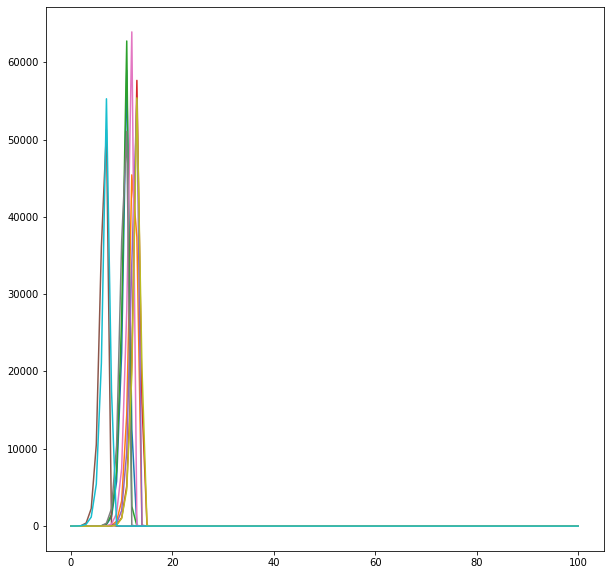

In [132]:
ts_data = pd.DataFrame(np.array([x[:,1] for x in disease_matrix_ts]))
ts_data.plot(legend=False)


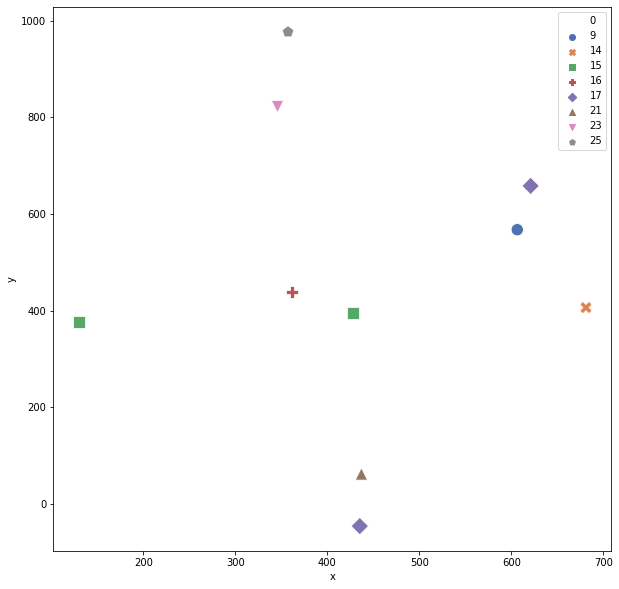

In [102]:
# scatter plot to help visualize timing of peaks
peak_timings=ts_data.idxmax(axis=0)
network_timings = pd.concat([disease_network,peak_timings],axis=1)
sns.scatterplot(data=network_timings,x='x',y='y',hue=0,style=0,palette="deep",s=150)

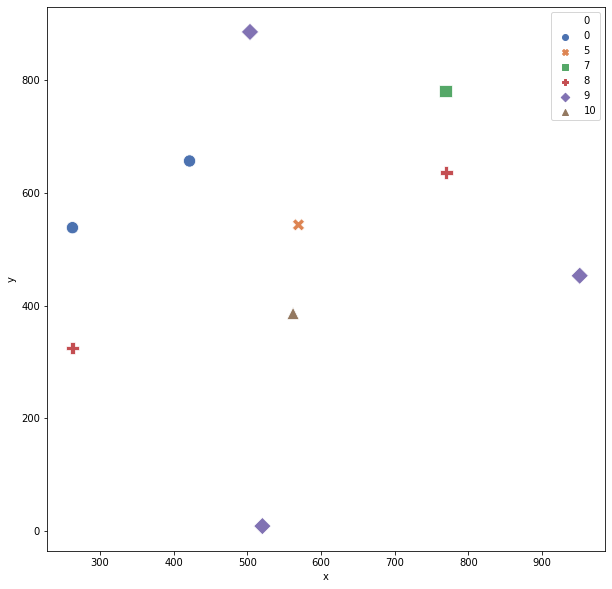

In [72]:
# scatterplot helping to visualize timing of first case
first_cases=ts_data.ne(0).idxmax()
network_first_cases = pd.concat([disease_network,first_cases],axis=1)
sns.scatterplot(data=network_first_cases,x='x',y='y',hue=0,style=0,palette="deep",s=150)

In [43]:
disease_matrix_ts

[array([[1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 1.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [9.9996e+04, 4.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0.0000e+00],
        [1.0000e+05, 0.0000e+00, 0